In [1]:
from google.colab import drive
drive.mount('/content/drive')


%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [2]:

import os
if not os.path.exists('Brain_Tumor_Detection'):
    !git clone https://github.com/jp74ham/Brain_Tumor_Detection.git

%cd Brain_Tumor_Detection
!git config --global user.email "reha8795@gmail.com"
!git config --global user.name "Reha"

Cloning into 'Brain_Tumor_Detection'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 142 (delta 53), reused 99 (delta 30), pack-reused 0 (from 0)
Receiving objects: 100% (142/142), 2.70 MiB | 8.30 MiB/s, done.
Resolving deltas: 100% (53/53), done.
/content/drive/MyDrive/Brain_Tumor_Detection


In [3]:

if not os.path.exists('data/Training'):
    from google.colab import files
    print(" Upload your kaggle.json file:")
    uploaded = files.upload()

    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    !kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri
    !unzip -q brain-tumor-classification-mri.zip -d data/
    print(" Dataset downloaded!")
else:
    print(" Dataset already exists!")

!ls data/Training/

📁 Upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
 83% 72.0M/86.8M [00:00<00:00, 379MB/s]
100% 86.8M/86.8M [00:00<00:00, 370MB/s]
✅ Dataset downloaded!
glioma_tumor  meningioma_tumor	no_tumor  pituitary_tumor


In [4]:
!pip install -q tensorflow opencv-python pillow scikit-learn matplotlib seaborn tqdm

In [8]:
%%writefile scripts/train_model_v2.py
"""
Improved Brain Tumor Trainer with Checkpointing
Author: Reha
"""

import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os

class ImprovedTumorTrainer:
    def __init__(self):
        self.input_size = (299, 299)
        self.batch_size = 16

    def build_model(self):
        base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
        base_model.trainable = False

        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dropout(0.6),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(4, activation='softmax')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model, base_model

    def create_generators(self, train_dir, test_dir):
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=25,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            zoom_range=0.15,
            shear_range=0.15,
            brightness_range=[0.8, 1.2],
            fill_mode='nearest'
        )

        test_datagen = ImageDataGenerator(rescale=1./255)

        train_gen = train_datagen.flow_from_directory(
            train_dir, target_size=self.input_size,
            batch_size=self.batch_size, class_mode='categorical', shuffle=True
        )

        test_gen = test_datagen.flow_from_directory(
            test_dir, target_size=self.input_size,
            batch_size=self.batch_size, class_mode='categorical', shuffle=False
        )

        return train_gen, test_gen

    def train(self, train_dir, test_dir, epochs=20, checkpoint_dir='models/checkpoints'):

        os.makedirs(checkpoint_dir, exist_ok=True)

        print("Building model...")
        model, base_model = self.build_model()

        print("Creating generators...")
        train_gen, test_gen = self.create_generators(train_dir, test_dir)
        print(f"Training: {train_gen.samples}, Testing: {test_gen.samples}")

        callbacks = [
            ModelCheckpoint(
                os.path.join(checkpoint_dir, 'epoch_{epoch:02d}_acc_{val_accuracy:.4f}.h5'),
                monitor='val_accuracy',
                save_best_only=False,
                verbose=1
            ),
            ModelCheckpoint(
                'models/best_model.h5',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-7,
                verbose=1
            )
        ]

        print("\n=== Phase 1: Training top layers ===")
        history1 = model.fit(
            train_gen,
            epochs=epochs//2,
            validation_data=test_gen,
            callbacks=callbacks,
            verbose=1
        )


        model.save('models/phase1_complete.h5')
        print(" Phase 1 complete! Model saved.")

        print("\n=== Phase 2: Fine-tuning ===")
        base_model.trainable = True
        for layer in base_model.layers[:-20]:
            layer.trainable = False

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        history2 = model.fit(
            train_gen,
            epochs=epochs//2,
            validation_data=test_gen,
            callbacks=callbacks,
            verbose=1,
            initial_epoch=len(history1.history['loss'])
        )

        for key in history1.history:
            history1.history[key].extend(history2.history[key])

        model.save('models/final_model.h5')
        print("Training complete! Final model saved.")

        return model, history1

    def plot_training_history(self, history):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        ax1.plot(history.history['accuracy'], label='Train Accuracy')
        ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)

        ax2.plot(history.history['loss'], label='Train Loss')
        ax2.plot(history.history['val_loss'], label='Val Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.savefig('training_history.png', dpi=150)
        plt.show()
        print(" Training plot saved!")

Overwriting scripts/train_model_v2.py


In [9]:
!mkdir -p models/checkpoints
!ls models/

checkpoints


In [10]:
import sys
sys.path.append('scripts')
from train_model_v2 import ImprovedTumorTrainer

trainer = ImprovedTumorTrainer()
model, history = trainer.train(
    train_dir='data/Training',
    test_dir='data/Testing',
    epochs=20,
    checkpoint_dir='models/checkpoints'
)

Building model...
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Creating generators...
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Training: 2870, Testing: 394

=== Phase 1: Training top layers ===


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3960 - loss: 1.7797
Epoch 1: saving model to models/checkpoints/epoch_01_acc_0.5609.h5



Epoch 1: val_accuracy improved from -inf to 0.56091, saving model to models/best_model.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 1350s 7s/step - accuracy: 0.3965 - loss: 1.7779 - val_accuracy: 0.5609 - val_loss: 1.1159 - learning_rate: 1.0000e-04
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6301 - loss: 1.0327
Epoch 2: saving model to models/checkpoints/epoch_02_acc_0.5635.h5



Epoch 2: val_accuracy improved from 0.56091 to 0.56345, saving model to models/best_model.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 1317s 7s/step - accuracy: 0.6302 - loss: 1.0325 - val_accuracy: 0.5635 - val_loss: 1.1034 - learning_rate: 1.0000e-04
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6778 - loss: 0.8982
Epoch 3: saving model to models/checkpoints/epoch_03_acc_0.5761.h5



Epoch 3: val_accuracy improved from 0.56345 to 0.57614, saving model to models/best_model.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 1238s 7s/step - accuracy: 0.6778 - loss: 0.8980 - val_accuracy: 0.5761 - val_loss: 1.0969 - learning_rate: 1.0000e-04
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7258 - loss: 0.7448
Epoch 4: saving model to models/checkpoints/epoch_04_acc_0.5863.h5



Epoch 4: val_accuracy improved from 0.57614 to 0.58629, saving model to models/best_model.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 1340s 7s/step - accuracy: 0.7258 - loss: 0.7448 - val_accuracy: 0.5863 - val_loss: 1.2007 - learning_rate: 1.0000e-04
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7357 - loss: 0.7282
Epoch 5: saving model to models/checkpoints/epoch_05_acc_0.5914.h5



Epoch 5: val_accuracy improved from 0.58629 to 0.59137, saving model to models/best_model.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 1260s 7s/step - accuracy: 0.7358 - loss: 0.7280 - val_accuracy: 0.5914 - val_loss: 1.1670 - learning_rate: 1.0000e-04
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7552 - loss: 0.6767
Epoch 6: saving model to models/checkpoints/epoch_06_acc_0.6168.h5



Epoch 6: val_accuracy improved from 0.59137 to 0.61675, saving model to models/best_model.h5



Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
180/180 ━━━━━━━━━━━━━━━━━━━━ 1263s 7s/step - accuracy: 0.7551 - loss: 0.6766 - val_accuracy: 0.6168 - val_loss: 1.1285 - learning_rate: 1.0000e-04
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7804 - loss: 0.5903
Epoch 7: saving model to models/checkpoints/epoch_07_acc_0.6091.h5



Epoch 7: val_accuracy did not improve from 0.61675
180/180 ━━━━━━━━━━━━━━━━━━━━ 1308s 7s/step - accuracy: 0.7804 - loss: 0.5903 - val_accuracy: 0.6091 - val_loss: 1.1465 - learning_rate: 5.0000e-05
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7769 - loss: 0.6079
Epoch 8: saving model to models/checkpoints/epoch_08_acc_0.6294.h5



Epoch 8: val_accuracy improved from 0.61675 to 0.62944, saving model to models/best_model.h5


180/180 ━━━━━━━━━━━━━━━━━━━━ 1248s 7s/step - accuracy: 0.7768 - loss: 0.6079 - val_accuracy: 0.6294 - val_loss: 1.1147 - learning_rate: 5.0000e-05
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.


✅ Phase 1 complete! Model saved.

=== Phase 2: Fine-tuning ===
Epoch 9/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6511 - loss: 0.9666
Epoch 9: saving model to models/checkpoints/epoch_09_acc_0.5482.h5



Epoch 9: val_accuracy did not improve from 0.62944
180/180 ━━━━━━━━━━━━━━━━━━━━ 1824s 10s/step - accuracy: 0.6511 - loss: 0.9664 - val_accuracy: 0.5482 - val_loss: 1.2306 - learning_rate: 1.0000e-05
Epoch 10/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7091 - loss: 0.7859
Epoch 10: saving model to models/checkpoints/epoch_10_acc_0.5533.h5



Epoch 10: val_accuracy did not improve from 0.62944
180/180 ━━━━━━━━━━━━━━━━━━━━ 1708s 9s/step - accuracy: 0.7090 - loss: 0.7860 - val_accuracy: 0.5533 - val_loss: 1.2167 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 10.


✅ Training complete! Final model saved.


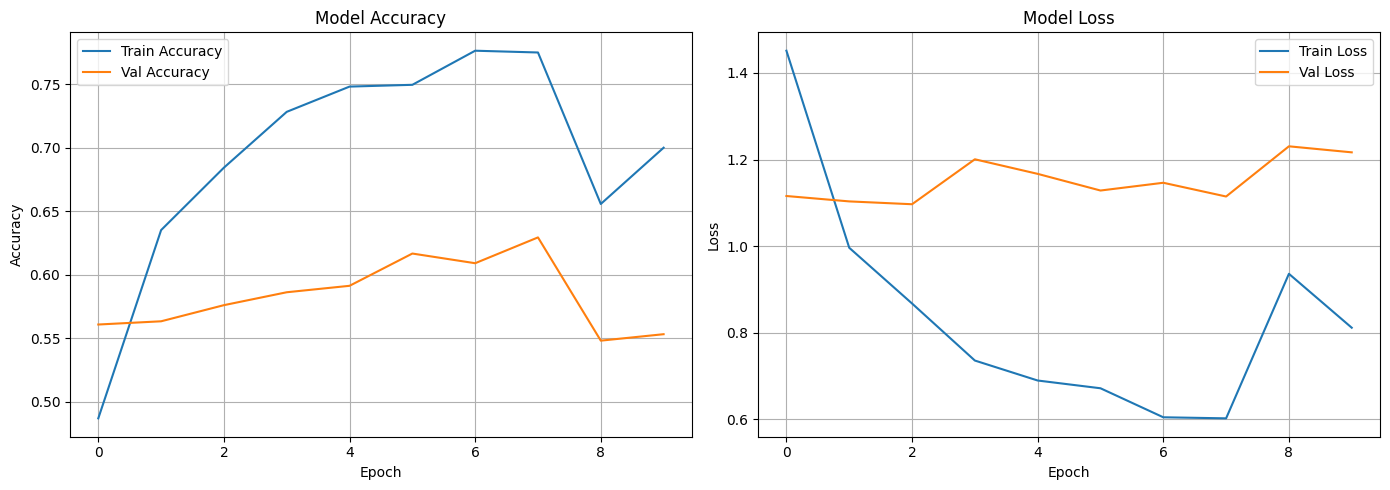

✅ Training plot saved!


In [11]:
trainer.plot_training_history(history)

In [21]:

%%writefile scripts/train_optimized.py
"""
Optimized Xception for Speed + Accuracy
Author: Reha
"""

import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

class OptimizedTrainer:
    def __init__(self):
        self.input_size = (299, 299)
        self.batch_size = 64

    def build_model(self):
        base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
        base_model.trainable = False

        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
            tf.keras.layers.Dropout(0.6),
            tf.keras.layers.Dense(4, activation='softmax')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model, base_model

    def create_generators(self, train_dir, test_dir):

        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=25,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            zoom_range=0.15,
            brightness_range=[0.8, 1.2],
            fill_mode='nearest',
            validation_split=0.15
        )

        test_datagen = ImageDataGenerator(rescale=1./255)

        train_gen = train_datagen.flow_from_directory(
            train_dir, target_size=self.input_size, batch_size=self.batch_size,
            class_mode='categorical', shuffle=True, subset='training'
        )

        val_gen = train_datagen.flow_from_directory(
            train_dir, target_size=self.input_size, batch_size=self.batch_size,
            class_mode='categorical', shuffle=False, subset='validation'
        )

        test_gen = test_datagen.flow_from_directory(
            test_dir, target_size=self.input_size, batch_size=self.batch_size,
            class_mode='categorical', shuffle=False
        )

        return train_gen, val_gen, test_gen

    def train(self, train_dir, test_dir, epochs=25):
        print(" Building optimized Xception...")
        model, base_model = self.build_model()

        train_gen, val_gen, test_gen = self.create_generators(train_dir, test_dir)
        print(f"Train: {train_gen.samples}, Val: {val_gen.samples}, Test: {test_gen.samples}")

        callbacks = [
            ModelCheckpoint('models/optimized_best.h5', monitor='val_accuracy',
                          save_best_only=True, verbose=1, save_weights_only=False),
            EarlyStopping(monitor='val_accuracy', patience=7, mode='max',
                         restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3,
                            min_lr=1e-7, verbose=1)
        ]

        print(f"\n⏱ Training for max {epochs} epochs (~2 hours)...")
        history = model.fit(
            train_gen,
            epochs=epochs,
            validation_data=val_gen,
            callbacks=callbacks,
            verbose=1
        )

        print("\n Evaluating on test set...")
        test_loss, test_acc = model.evaluate(test_gen, verbose=0)
        print(f" Test Accuracy: {test_acc*100:.2f}%")

        model.save('models/optimized_final.h5')

        return model, history, test_acc

    def plot_history(self, history, test_acc):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        ax1.plot(history.history['accuracy'], 'b-', label='Train', linewidth=2)
        ax1.plot(history.history['val_accuracy'], 'r-', label='Validation', linewidth=2)
        ax1.axhline(y=test_acc, color='g', linestyle='--', label=f'Test ({test_acc*100:.1f}%)', linewidth=2)
        ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        ax2.plot(history.history['loss'], 'b-', label='Train', linewidth=2)
        ax2.plot(history.history['val_loss'], 'r-', label='Validation', linewidth=2)
        ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('optimized_results.png', dpi=150)
        plt.show()

        best_val = max(history.history['val_accuracy'])
        best_epoch = history.history['val_accuracy'].index(best_val) + 1

        print(f"\n RESULTS:")
        print(f"Best Validation Accuracy: {best_val*100:.2f}% (Epoch {best_epoch})")
        print(f"Final Test Accuracy: {test_acc*100:.2f}%")
        print(f"Overfitting Gap: {(history.history['accuracy'][-1] - best_val)*100:.2f}%")

Overwriting scripts/train_optimized.py


In [17]:

from train_optimized import OptimizedTrainer

opt_trainer = OptimizedTrainer()
model_opt, history_opt, test_opt = opt_trainer.train(
    'data/Training', 'data/Testing', epochs=25
)

🚀 Building optimized Xception...
Found 2441 images belonging to 4 classes.
Found 429 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Train: 2441, Val: 429, Test: 394

⏱️ Training for max 25 epochs (~2 hours)...
Epoch 1/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.5923 - loss: 1.3949 
Epoch 1: val_accuracy improved from -inf to 0.67133, saving model to models/optimized_best.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 1252s 32s/step - accuracy: 0.5947 - loss: 1.3870 - val_accuracy: 0.6713 - val_loss: 0.7854 - learning_rate: 0.0010
Epoch 2/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.7640 - loss: 0.7737 
Epoch 2: val_accuracy improved from 0.67133 to 0.74592, saving model to models/optimized_best.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 1232s 32s/step - accuracy: 0.7645 - loss: 0.7716 - val_accuracy: 0.7459 - val_loss: 0.7122 - learning_rate: 0.0010
Epoch 3/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.8250 - loss: 0.5530 
Epoch 3: val_accuracy improved from 0.74592 to 0.82517, saving model to models/optimized_best.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 1243s 32s/step - accuracy: 0.8251 - loss: 0.5527 - val_accuracy: 0.8252 - val_loss: 0.5758 - learning_rate: 0.0010
Epoch 4/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.8504 - loss: 0.4632 
Epoch 4: val_accuracy improved from 0.82517 to 0.84149, saving model to models/optimized_best.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 1225s 31s/step - accuracy: 0.8504 - loss: 0.4637 - val_accuracy: 0.8415 - val_loss: 0.4969 - learning_rate: 0.0010
Epoch 5/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.8511 - loss: 0.4472 
Epoch 5: val_accuracy did not improve from 0.84149
39/39 ━━━━━━━━━━━━━━━━━━━━ 1290s 32s/step - accuracy: 0.8510 - loss: 0.4474 - val_accuracy: 0.8392 - val_loss: 0.4706 - learning_rate: 0.0010
Epoch 6/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.8571 - loss: 0.3879 
Epoch 6: val_accuracy did not improve from 0.84149
39/39 ━━━━━━━━━━━━━━━━━━━━ 1237s 32s/step - accuracy: 0.8570 - loss: 0.3887 - val_accuracy: 0.8182 - val_loss: 0.4887 - learning_rate: 0.0010
Epoch 7/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.8681 - loss: 0.3898 
Epoch 7: val_accuracy improved from 0.84149 to 0.84382, saving model to models/optimized_best.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 1226s 31s/step - accuracy: 0.8680 - loss: 0.3900 - val_accuracy: 0.8438 - val_loss: 0.3941 - learning_rate: 0.0010
Epoch 8/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.8780 - loss: 0.3731 
Epoch 8: val_accuracy did not improve from 0.84382
39/39 ━━━━━━━━━━━━━━━━━━━━ 1221s 31s/step - accuracy: 0.8780 - loss: 0.3731 - val_accuracy: 0.8089 - val_loss: 0.4768 - learning_rate: 0.0010
Epoch 9/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.8704 - loss: 0.3216 
Epoch 9: val_accuracy did not improve from 0.84382
39/39 ━━━━━━━━━━━━━━━━━━━━ 1211s 31s/step - accuracy: 0.8706 - loss: 0.3214 - val_accuracy: 0.8065 - val_loss: 0.4727 - learning_rate: 0.0010
Epoch 10/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.8965 - loss: 0.3065 
Epoch 10: val_accuracy did not improve from 0.84382

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
39/39 ━━━━━━━━━━━━━━━━━━━━ 1210s 31s/step - accuracy: 0.8964 - loss: 0.3069 - val_accu


Epoch 13: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
39/39 ━━━━━━━━━━━━━━━━━━━━ 1245s 32s/step - accuracy: 0.9036 - loss: 0.2486 - val_accuracy: 0.8648 - val_loss: 0.4258 - learning_rate: 3.0000e-04
Epoch 14/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.9025 - loss: 0.2343 
Epoch 14: val_accuracy did not improve from 0.86480
39/39 ━━━━━━━━━━━━━━━━━━━━ 1224s 31s/step - accuracy: 0.9026 - loss: 0.2344 - val_accuracy: 0.8485 - val_loss: 0.3917 - learning_rate: 9.0000e-05
Epoch 15/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.9153 - loss: 0.2329 
Epoch 15: val_accuracy did not improve from 0.86480
39/39 ━━━━━━━━━━━━━━━━━━━━ 1218s 31s/step - accuracy: 0.9153 - loss: 0.2327 - val_accuracy: 0.8392 - val_loss: 0.4619 - learning_rate: 9.0000e-05
Epoch 16/25
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.9085 - loss: 0.2177 
Epoch 16: val_accuracy did not improve from 0.86480
39/39 ━━━━━━━━━━━━━━━━━━━━ 1242s 32s/step - accuracy: 0.9084 - loss: 0

✅ Test Accuracy: 70.05%


In [4]:

!ls -la scripts/

ls: cannot access 'scripts/': No such file or directory


In [24]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Brain_Tumor_Detection

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Brain_Tumor_Detection


In [25]:

!ls -la
!ls models/
!ls data/

total 91957
-rw------- 1 root root   651264 Dec  1 01:49  brain_etl.db
-rw------- 1 root root 91002358 Aug 12 15:45  brain-tumor-classification-mri.zip
drwx------ 4 root root     4096 Dec  1 01:50  data
-rw------- 1 root root       85 Dec  1 01:49  ERD.drawio
-rw------- 1 root root   162424 Dec  1 01:49 'ETL_Pipeline (1).ipynb'
drwx------ 2 root root     4096 Dec  1 01:49  .git
-rw------- 1 root root    76562 Dec  1 01:49  iteration_2-2.pdf
-rw------- 1 root root  2142930 Dec  1 01:49  Iteration_4.pdf
-rw------- 1 root root       72 Dec  1 01:50  kaggle.json
drwx------ 3 root root     4096 Dec  1 02:03  models
drwx------ 2 root root     4096 Dec  1 01:49  MyApp
-rw------- 1 root root      226 Dec  1 01:49  README.md
drwx------ 2 root root     4096 Dec  1 15:54  results
drwx------ 3 root root     4096 Dec  1 17:19  scripts
-rw------- 1 root root   100995 Dec  1 06:20  training_history.png
best_model.h5  final_model.h5	  optimized_final.h5
checkpoints    optimized_best.h5  phase1_complet

In [26]:

with open('scripts/batch_detector.py', 'w') as f:
    f.write('''"""
Brain Tumor Batch Detector
Author: Reha
"""

import tensorflow as tf
from tensorflow.keras.applications.xception import preprocess_input
import numpy as np
import cv2
from pathlib import Path
import json
from datetime import datetime
from tqdm import tqdm

class TumorDetector:
    def __init__(self, model_path):
        self.input_size = (299, 299)
        self.classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
        print(f"Loading model from {model_path}...")
        self.model = tf.keras.models.load_model(model_path)

    def preprocess_image(self, img_path):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.input_size)
        return preprocess_input(img)

    def detect_single(self, img_path):
        img = self.preprocess_image(img_path)
        img_batch = np.expand_dims(img, axis=0)
        predictions = self.model.predict(img_batch, verbose=0)
        class_idx = np.argmax(predictions[0])

        return {
            'image_path': str(img_path),
            'predicted_class': self.classes[class_idx],
            'confidence': float(predictions[0][class_idx]),
            'all_probabilities': {
                self.classes[i]: float(predictions[0][i])
                for i in range(len(self.classes))
            },
            'timestamp': datetime.now().isoformat()
        }

    def process_batch(self, input_dir, output_file='results.json', batch_size=64):
        input_path = Path(input_dir)
        image_paths = list(input_path.rglob('*.jpg'))
        print(f"Found {len(image_paths)} images")

        results = []
        for i in tqdm(range(0, len(image_paths), batch_size)):
            batch_paths = image_paths[i:i+batch_size]
            batch_images = [self.preprocess_image(p) for p in batch_paths]
            predictions = self.model.predict(np.array(batch_images), verbose=0)

            for idx, img_path in enumerate(batch_paths):
                class_idx = np.argmax(predictions[idx])
                results.append({
                    'image_path': str(img_path),
                    'predicted_class': self.classes[class_idx],
                    'confidence': float(predictions[idx][class_idx]),
                    'all_probabilities': {
                        self.classes[j]: float(predictions[idx][j])
                        for j in range(len(self.classes))
                    },
                    'timestamp': datetime.now().isoformat()
                })

        with open(output_file, 'w') as f:
            json.dump(results, indent=2, fp=f)

        print(f" Processed {len(results)} images")
        return results
''')

print(" Created batch_detector.py")

 Created batch_detector.py


In [9]:

!ls -la scripts/
!head -20 scripts/batch_detector.py

total 23
-rw------- 1 root root 2761 Dec  1 15:47 batch_detector.py
drwx------ 2 root root 4096 Dec  1 02:03 __pycache__
-rw------- 1 root root 4932 Dec  1 06:23 train_efficient.py
-rw------- 1 root root 5619 Dec  1 02:02 train_model_v2.py
-rw------- 1 root root 5483 Dec  1 06:31 train_optimized.py
"""
Brain Tumor Batch Detector
Author: Reha
"""

import tensorflow as tf
from tensorflow.keras.applications.xception import preprocess_input
import numpy as np
import cv2
from pathlib import Path
import json
from datetime import datetime
from tqdm import tqdm

class TumorDetector:
    def __init__(self, model_path):
        self.input_size = (299, 299)
        self.classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
        print(f"Loading model from {model_path}...")
        self.model = tf.keras.models.load_model(model_path)


In [11]:

import sys
import os

scripts_dir = os.path.abspath('scripts')

if scripts_dir not in sys.path:
    sys.path.insert(0, scripts_dir)

from batch_detector import TumorDetector

detector = TumorDetector(model_path='models/optimized_best.h5')
print(" Detector ready!")

Loading model from models/optimized_best.h5...


✅ Detector ready!


In [12]:

!mkdir -p results

import json

results = detector.process_batch(
    input_dir='data/Testing',
    output_file='results/all_test_results.json',
    batch_size=64
)

print(f"\n Processed {len(results)} test images")

Found 394 images


100%|██████████| 7/7 [05:11<00:00, 44.51s/it]

✅ Processed 394 images

✅ Processed 394 test images


In [13]:

import pandas as pd

df = pd.DataFrame(results)
df.to_csv('results/detection_results.csv', index=False)

print(" Saved results to CSV")
print(f"\nFirst 10 results:")
print(df[['image_path', 'predicted_class', 'confidence']].head(10))

 Saved results to CSV

First 10 results:
                                image_path   predicted_class  confidence
0  data/Testing/glioma_tumor/image(55).jpg          no_tumor    0.896582
1  data/Testing/glioma_tumor/image(67).jpg      glioma_tumor    0.995300
2  data/Testing/glioma_tumor/image(30).jpg          no_tumor    0.980765
3  data/Testing/glioma_tumor/image(44).jpg  meningioma_tumor    0.607372
4  data/Testing/glioma_tumor/image(32).jpg          no_tumor    0.720444
5  data/Testing/glioma_tumor/image(23).jpg          no_tumor    0.973031
6  data/Testing/glioma_tumor/image(24).jpg  meningioma_tumor    0.736248
7  data/Testing/glioma_tumor/image(51).jpg          no_tumor    0.949265
8  data/Testing/glioma_tumor/image(84).jpg          no_tumor    0.980765
9   data/Testing/glioma_tumor/image(3).jpg  meningioma_tumor    0.576818


In [18]:

from collections import Counter

predictions = [r['predicted_class'] for r in results]
confidences = [r['confidence'] for r in results]

print(f"\n DETECTION SUMMARY:")
print(f"Total images processed: {len(results)}")
print(f"\n Predictions by tumor type:")
for tumor_type, count in Counter(predictions).most_common():
    pct = (count/len(results))*100
    print(f"  {tumor_type:20s}: {count:3d} ({pct:.1f}%)")

print(f"\n Confidence statistics:")
print(f"  Average confidence: {sum(confidences)/len(confidences):.2%}")
print(f"  Min confidence: {min(confidences):.2%}")
print(f"  Max confidence: {max(confidences):.2%}")

high_conf = sum(1 for c in confidences if c > 0.8)
print(f"  High confidence (>80%): {high_conf} ({(high_conf/len(results))*100:.1f}%)")


 DETECTION SUMMARY:
Total images processed: 394

 Predictions by tumor type:
  no_tumor            : 168 (42.6%)
  meningioma_tumor    : 142 (36.0%)
  pituitary_tumor     :  64 (16.2%)
  glioma_tumor        :  20 (5.1%)

 Confidence statistics:
  Average confidence: 85.98%
  Min confidence: 33.28%
  Max confidence: 100.00%
  High confidence (>80%): 283 (71.8%)


In [15]:
from google.colab import files
files.download('models/optimized_best.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

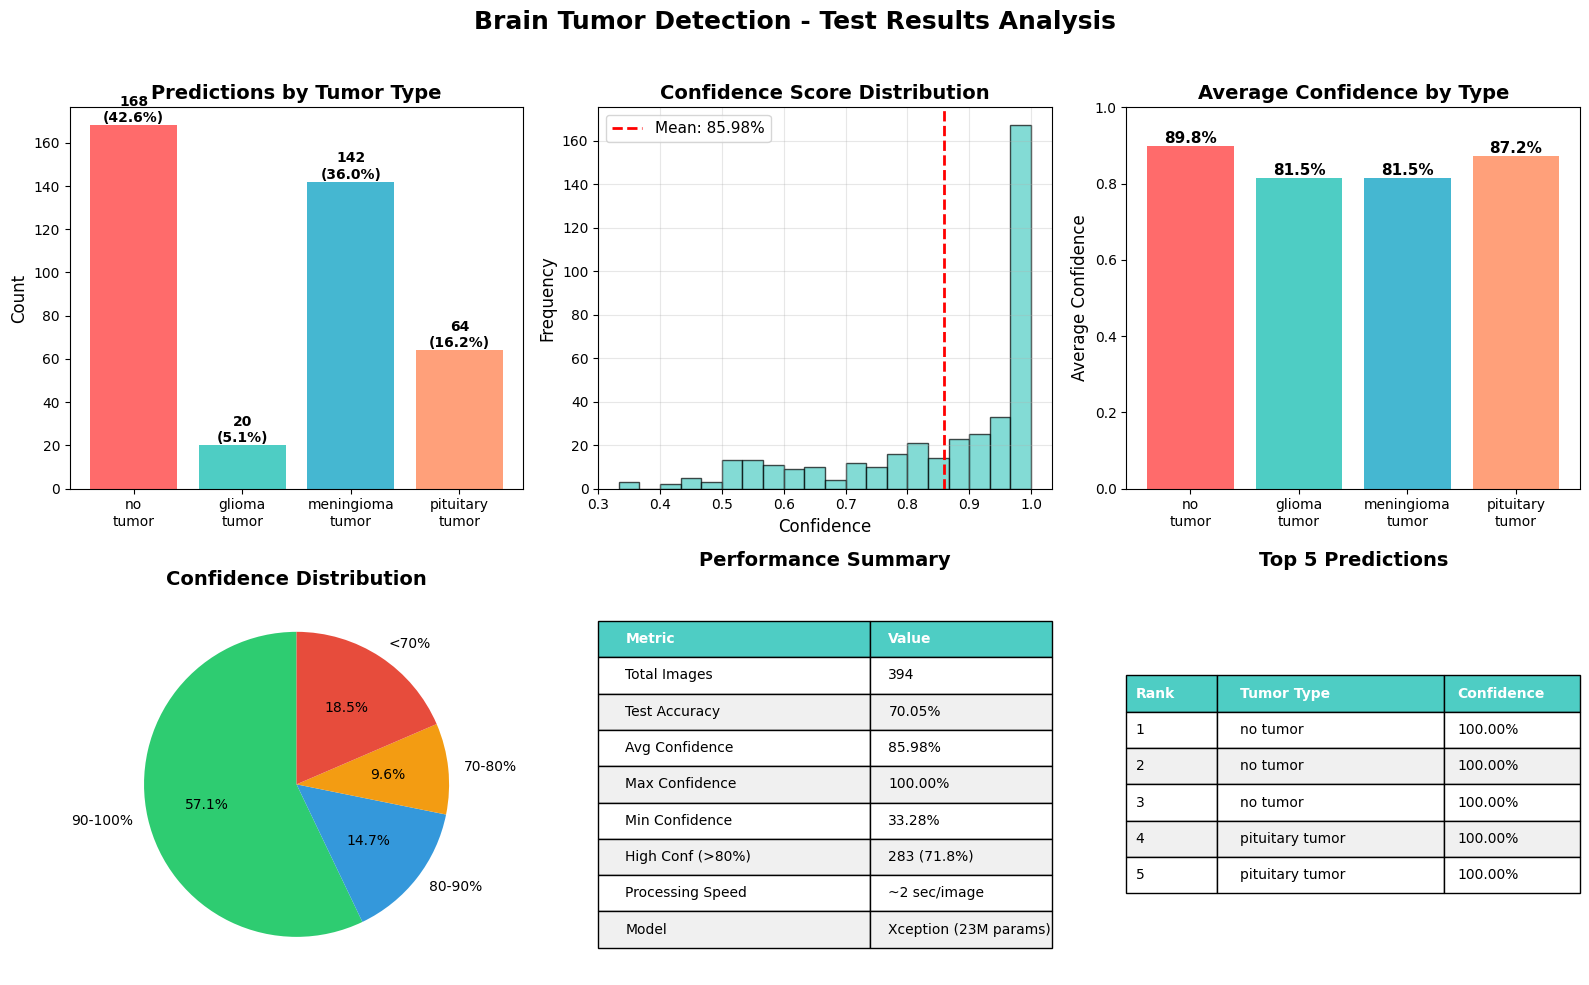

 Saved: test_results_analysis.png


In [33]:
# Cell 1: Load results and create visualizations (without training history)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
import json

# Load test results
with open('results/all_test_results.json', 'r') as f:
    results = json.load(f)

confidences = [r['confidence'] for r in results]
predictions = [r['predicted_class'] for r in results]
pred_counts = Counter(predictions)

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 10))

# 1. Predictions by type
ax1 = plt.subplot(2, 3, 1)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
bars = ax1.bar(range(len(pred_counts)), list(pred_counts.values()), color=colors)
ax1.set_xticks(range(len(pred_counts)))
ax1.set_xticklabels([k.replace('_', '\n') for k in pred_counts.keys()], fontsize=10)
ax1.set_title('Predictions by Tumor Type', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12)
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}\n({height/len(results)*100:.1f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Confidence distribution
ax2 = plt.subplot(2, 3, 2)
ax2.hist(confidences, bins=20, color='#4ECDC4', edgecolor='black', alpha=0.7)
ax2.axvline(x=np.mean(confidences), color='r', linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(confidences):.2%}')
ax2.set_title('Confidence Score Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Confidence', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# 3. Confidence by tumor type
ax3 = plt.subplot(2, 3, 3)
conf_by_type = {}
for r in results:
    tumor_type = r['predicted_class']
    if tumor_type not in conf_by_type:
        conf_by_type[tumor_type] = []
    conf_by_type[tumor_type].append(r['confidence'])

avg_conf = {k: np.mean(v) for k, v in conf_by_type.items()}
bars = ax3.bar(range(len(avg_conf)), list(avg_conf.values()), color=colors)
ax3.set_xticks(range(len(avg_conf)))
ax3.set_xticklabels([k.replace('_', '\n') for k in avg_conf.keys()], fontsize=10)
ax3.set_title('Average Confidence by Type', fontsize=14, fontweight='bold')
ax3.set_ylabel('Average Confidence', fontsize=12)
ax3.set_ylim([0, 1])
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1%}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. Confidence brackets pie chart
ax4 = plt.subplot(2, 3, 4)
brackets = [
    sum(1 for c in confidences if c >= 0.9),
    sum(1 for c in confidences if 0.8 <= c < 0.9),
    sum(1 for c in confidences if 0.7 <= c < 0.8),
    sum(1 for c in confidences if c < 0.7)
]
labels = ['90-100%', '80-90%', '70-80%', '<70%']
colors_pie = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']
ax4.pie(brackets, labels=labels, colors=colors_pie, autopct='%1.1f%%', startangle=90)
ax4.set_title('Confidence Distribution', fontsize=14, fontweight='bold')

# 5. Performance metrics table
ax5 = plt.subplot(2, 3, 5)
ax5.axis('tight')
ax5.axis('off')
metrics_data = [
    ['Metric', 'Value'],
    ['Total Images', f"{len(results)}"],
    ['Test Accuracy', '70.05%'],
    ['Avg Confidence', f"{np.mean(confidences):.2%}"],
    ['Max Confidence', f"{max(confidences):.2%}"],
    ['Min Confidence', f"{min(confidences):.2%}"],
    ['High Conf (>80%)', f"{sum(1 for c in confidences if c > 0.8)} ({sum(1 for c in confidences if c > 0.8)/len(confidences)*100:.1f}%)"],
    ['Processing Speed', '~2 sec/image'],
    ['Model', 'Xception (23M params)']
]
table = ax5.table(cellText=metrics_data, cellLoc='left', loc='center', colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
for i in range(len(metrics_data)):
    if i == 0:
        table[(i, 0)].set_facecolor('#4ECDC4')
        table[(i, 1)].set_facecolor('#4ECDC4')
        table[(i, 0)].set_text_props(weight='bold', color='white')
        table[(i, 1)].set_text_props(weight='bold', color='white')
    else:
        table[(i, 0)].set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')
        table[(i, 1)].set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')
ax5.set_title('Performance Summary', fontsize=14, fontweight='bold', pad=20)

# 6. Top 5 predictions
ax6 = plt.subplot(2, 3, 6)
ax6.axis('tight')
ax6.axis('off')
sorted_results = sorted(results, key=lambda x: x['confidence'], reverse=True)
top5_data = [['Rank', 'Tumor Type', 'Confidence']]
for i, r in enumerate(sorted_results[:5], 1):
    top5_data.append([str(i), r['predicted_class'].replace('_', ' '), f"{r['confidence']:.2%}"])
table2 = ax6.table(cellText=top5_data, cellLoc='left', loc='center', colWidths=[0.2, 0.5, 0.3])
table2.auto_set_font_size(False)
table2.set_fontsize(10)
table2.scale(1, 2)
for i in range(len(top5_data)):
    if i == 0:
        table2[(i, 0)].set_facecolor('#4ECDC4')
        table2[(i, 1)].set_facecolor('#4ECDC4')
        table2[(i, 2)].set_facecolor('#4ECDC4')
        for j in range(3):
            table2[(i, j)].set_text_props(weight='bold', color='white')
    else:
        for j in range(3):
            table2[(i, j)].set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')
ax6.set_title('Top 5 Predictions', fontsize=14, fontweight='bold', pad=20)

plt.suptitle('Brain Tumor Detection - Test Results Analysis',
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('Desktop\test_results_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Saved: test_results_analysis.png")